# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [ ]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [ ]:
def gini(x: np.ndarray) -> float:
    un, count = np.unique(x, return_counts = True)
    func = lambda i: i*(1-i)
    return np.sum(func(count/x.size))

    
def entropy(x: np.ndarray) -> float:
    un, count = np.unique(x, return_counts = True)
    func = lambda i: i*np.log2(i)
    return -np.sum(func(count/x.size))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    full_y = np.hstack((left_y, right_y))
    return criterion(full_y) - criterion(left_y)*(left_y.size/full_y.size) \
    - criterion(right_y)*(right_y.size/full_y.size)

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, X):
        self.X = X
        un, count = np.unique(X, return_counts = True)
        self.prob = dict(zip(un, count/X.size))
        self.y = un[np.argmax(count)]
        

class DecisionTreeNode:

    def __init__(self, split_dim: int, split_value: float, 
                 left: Union['DecisionTreeNode', DecisionTreeLeaf], 
                 right: Union['DecisionTreeNode', DecisionTreeLeaf],
                 depth=0):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.depth=depth

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [ ]:
class DecisionTreeClassifier:

    def __init__(self, criterion : str = "entropy", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):

        self.criterion = globals()[criterion]
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        self.root = self.rec_split(X, y, 0)
        self.classes = np.unique(y)
        
    def rec_split(self, X ,y, cur_depth):
        features_num = X.shape[1]
        samples_num = X.shape[0]
        if self.max_depth > cur_depth and X.size > self.min_samples_leaf:
            max_gain=0
            for feat in range(features_num):
                feat_vals = X[:,feat]
                split_args = np.argsort(feat_vals)
                for i, val in enumerate(feat_vals[split_args]):
                    left_keys, right_keys = y[split_args[:i]], y[split_args[i:]]
                    cur_gain = gain(left_keys, right_keys, self.criterion)
                    if cur_gain>max_gain:
                        split_arg = i
                        max_gain = cur_gain
                        split_value = val
                        split_dim = feat
                        split_dim_args = split_args
            if np.unique(y).size == 1:
                return DecisionTreeLeaf(y)
            left_vals, right_vals = X[
                          split_dim_args[:split_arg]], X[split_dim_args[split_arg:]]
            left_keys, right_keys = y[
                          split_dim_args[:split_arg]], y[split_dim_args[split_arg:]]
            left_node = self.rec_split(left_vals, left_keys, cur_depth+1)
            right_node = self.rec_split(right_vals, right_keys, cur_depth+1)
            return DecisionTreeNode(split_dim, split_value, left_node, right_node, cur_depth)
        return DecisionTreeLeaf(y)
    def find_leaf(self, node, X, index):
        if  type(node) is DecisionTreeLeaf:
            for i in index:
                self.predicted[i] = node.prob
            return self.predicted
        mask = X[:,node.split_dim]<node.split_value
        left_index, right_index = index[mask], index[~mask]
        left_find, right_find = X[mask], X[~mask]
        self.find_leaf(node.left, left_find, left_index)
        self.find_leaf(node.right, right_find, right_index)

    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:
        self.predicted=[dict.fromkeys(self.classes)]*X.shape[0]
        
        self.find_leaf(self.root, X, np.arange(X.shape[0]))
        return self.predicted
    
    def predict(self, X : np.ndarray) -> list:
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [ ]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [ ]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

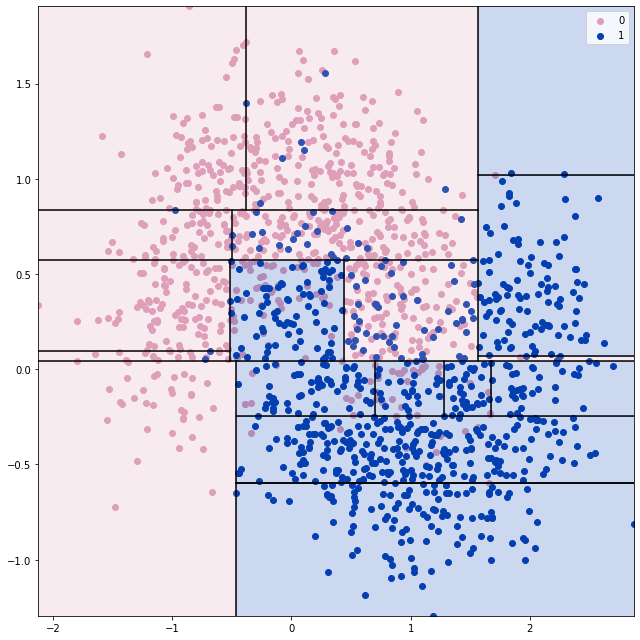

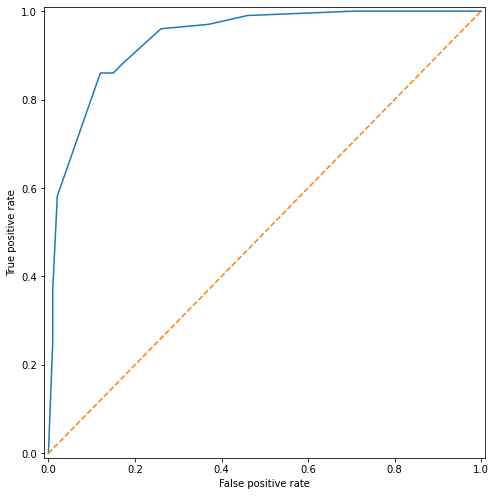

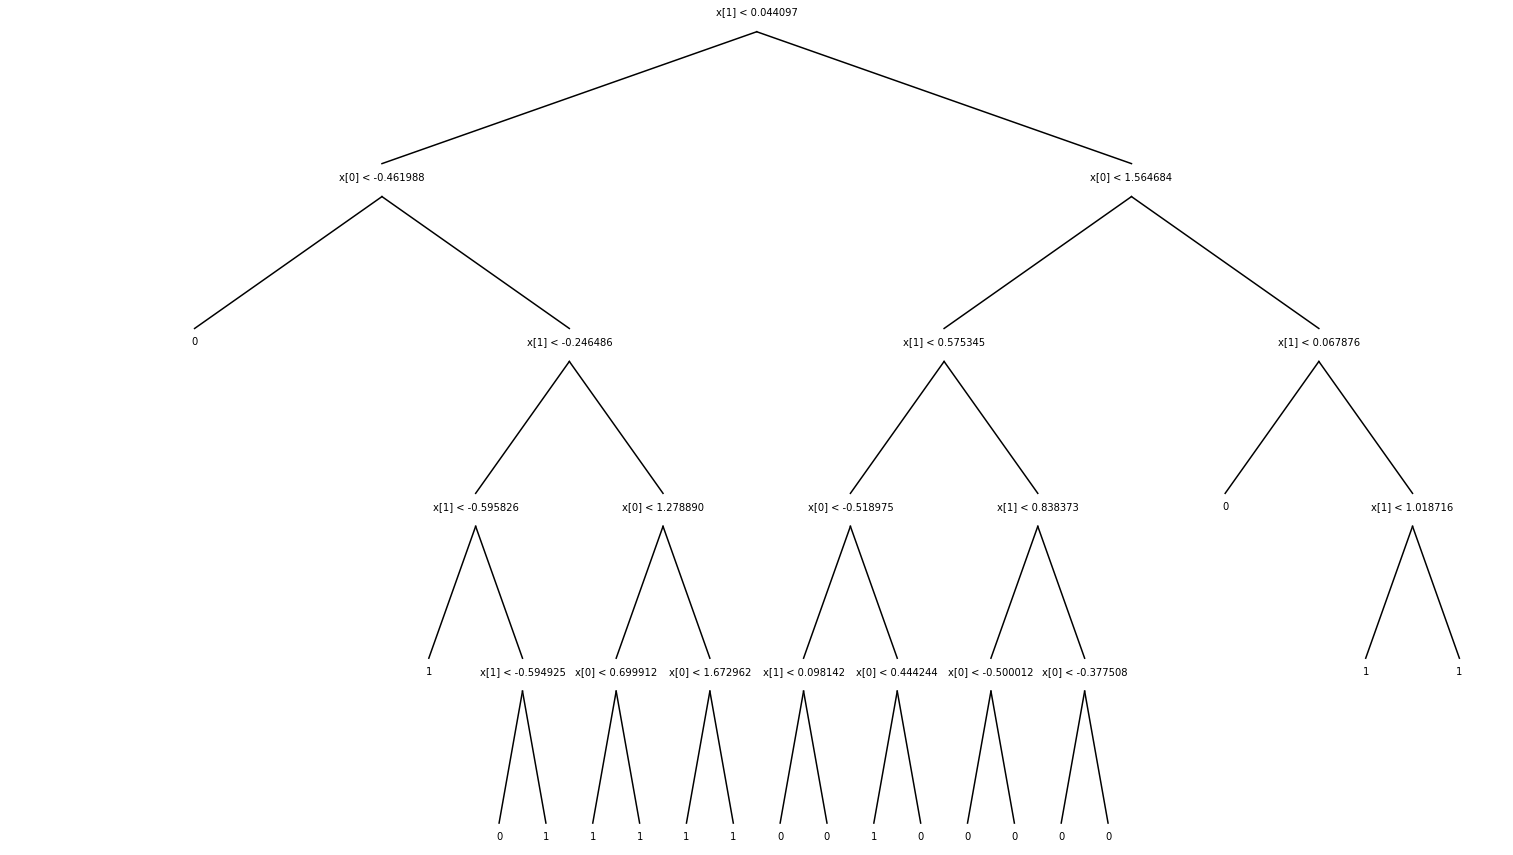

In [ ]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

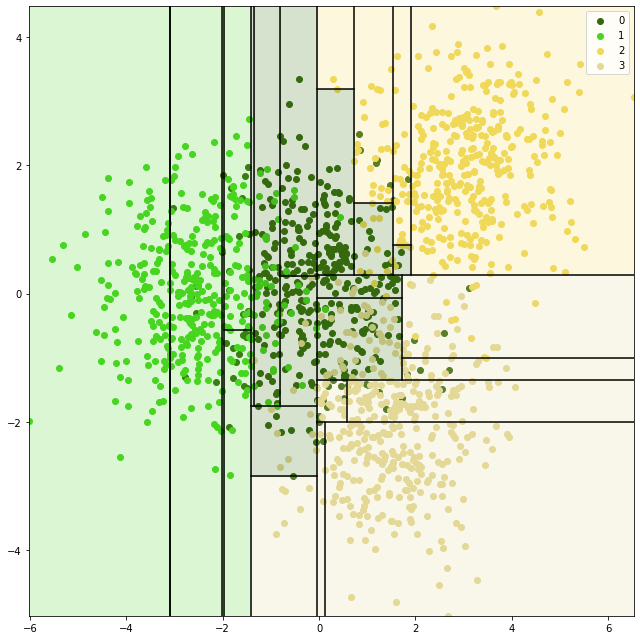

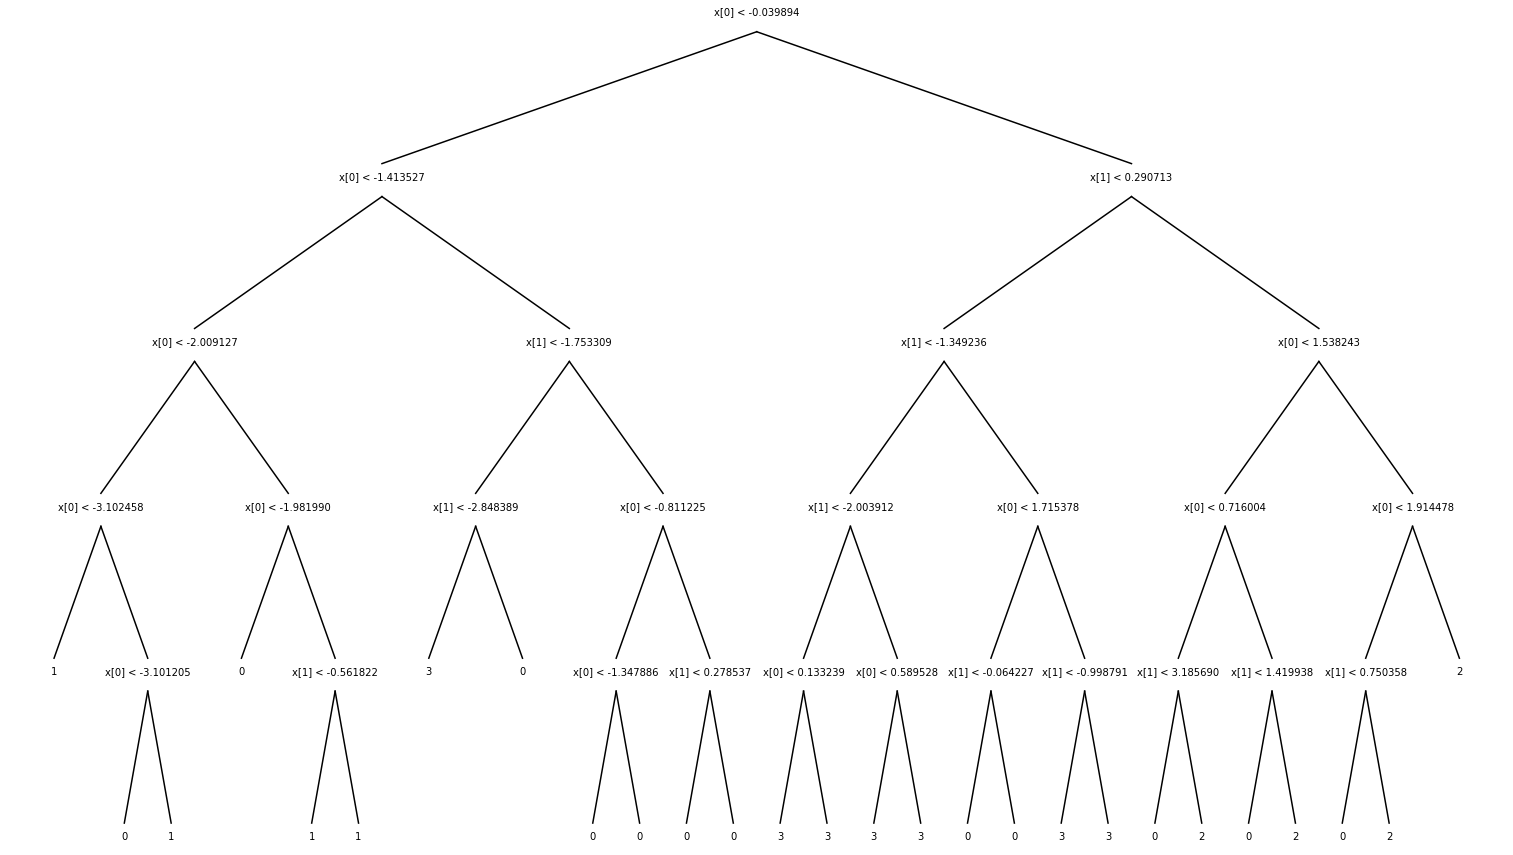

In [ ]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [ ]:
def read_dataset(path):
    dataframe = pandas.read_csv(path)
    features = dataframe.columns[1:]
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y), np.array(features)

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 0: cd: /MyDrive/: No such file or directory


In [ ]:
from pandas.core.strings import accessor
X, y, features = read_dataset("/content/drive/MyDrive/train.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=30)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
acc = np.sum(y_pred == y_test)/len(y_pred)
print(acc)

dtc.fit(X, y)


0.9333333333333333


### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [ ]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    pred_class, answer = dtc.predict(X), []
    for num, player in enumerate(X):
        explanation='because \n'
        node = dtc.root
        count=0
        while type(node) is DecisionTreeNode:
            count+=1
            if player[node.split_dim] >= node.split_value:
                explanation += ' ({}) {} = {:.4} >= {:.4} => \n'.format(count, features[node.split_dim], player[node.split_dim] ,node.split_value)
                node = node.right
            else:
                explanation += ' ({}) {} = {:.4} < {:.4} => \n'.format(count, features[node.split_dim], player[node.split_dim] ,node.split_value)
                node = node.left

        explanation += 'your class is {}'.format(pred_class[num])
        answer.append([pred_class[num], explanation])
    return answer

In [ ]:
X, y, features = read_dataset("/content/drive/MyDrive/train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: warrior
Explanation: because 
 (1) death in pvp percentage = 0.9 >= 0.4864 => 
 (2) death in pvp percentage = 0.9 < 0.9169 => 
 (3) player kills per death = 0.1281 < 2.419 => 
 (4) accuracy = 0.37 < 0.8176 => 
 (5) death in pvp percentage = 0.9 >= 0.8897 => 
your class is warrior

Class: cleric
Explanation: because 
 (1) death in pvp percentage = 0.007048 < 0.4864 => 
 (2) player kills per death = 0.2376 < 0.6383 => 
 (3) monster kills per death = 0.1207 < 2.145 => 
 (4) monster kills per death = 0.1207 < 0.8511 => 
 (5) accuracy = 0.6009 < 1.0 => 
your class is cleric

Class: rogue
Explanation: because 
 (1) death in pvp percentage = 1.0 >= 0.4864 => 
 (2) death in pvp percentage = 1.0 >= 0.9169 => 
your class is rogue

Class: rogue
Explanation: because 
 (1) death in pvp percentage = 0.9174 >= 0.4864 => 
 (2) death in pvp percentage = 0.9174 >= 0.9169 => 
your class is rogue

Class: cleric
Explanation: because 
 (1) death in pvp percentage = 0.1163 < 0.4864 => 
 (2) player kil